In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mahakala as ma

from mahakala.grmhd.athenak import AthenakFluidModel
from mahakala.electrons import rlow_rhigh_model
from mahakala.transfer import synchrotron_coefficients, solve_specific_intensity, solve_specific_intensity_mine

jax is using the gpu


In [3]:
fname = '../data/torus.mhd_w_bcc.01500.athdf'
fname = 'torus.mhd_w_bcc.01980.athdf'

bhspin = 0.9
fluid_gamma = 13./9

fluid_model = AthenakFluidModel(fname, bhspin)

100%|██████████| 456/456 [00:00<00:00, 515.66it/s]


In [4]:
observing_frequency = 230.e9
Mass_scale = 1e+26
M_bh = 6.2e9 * 1.989e33
r_high = 40

inclination_in_degrees = 60
distance_in_rg = 1000

fov = 10
number_pixels_across = 160

s0 = ma.initialize_geodesics_at_camera(bhspin, inclination_in_degrees, distance_in_rg, -fov, fov, number_pixels_across)

In [5]:
S, final_dt = ma.geodesic_integrator(10000, s0, 40, 1e-4, bhspin)

In [6]:
fluid_scalars = fluid_model.get_fluid_scalars_from_geodesics(S)

100%|██████████| 456/456 [00:30<00:00, 14.90it/s]


In [7]:
# compute supplementary quantities from fluid data and scales

bsq = fluid_scalars['b'] * fluid_scalars['b']

beta = fluid_scalars['u'] * (fluid_gamma - 1.) / bsq / 0.5
beta.at[np.isnan(beta)].set(0.)

sigma = bsq / fluid_scalars['dens']
sigma.at[np.isnan(sigma)].set(0.)

Theta_e = rlow_rhigh_model(fluid_scalars['dens'], fluid_scalars['u'], beta, r_high=r_high)

local_nu = - fluid_scalars['kdotu'] * observing_frequency
gamma_inv_data = local_nu / observing_frequency

units = fluid_model.get_units(M_bh, Mass_scale)

Ne_in_cgs = units['Ne_unit'] * fluid_scalars['dens']
B_in_gauss = units['B_unit'] * fluid_scalars['b']
pitch_angle = fluid_scalars['pitch_angle']

In [187]:
invariant_emissivity, invariant_absorptivity = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu, rescale_nu=1./observing_frequency)

In [189]:
# apply sigma cutoff

sigma_cutoff = 1.

invariant_emissivity = invariant_emissivity.at[sigma > sigma_cutoff].set(0.)
invariant_absorptivity = invariant_absorptivity.at[sigma > sigma_cutoff].set(0.)

In [190]:
rescaled_observing_frequency = 1.
final_I = solve_specific_intensity(invariant_emissivity, invariant_absorptivity, units['T_unit'] * final_dt, rescaled_observing_frequency)
final_image = final_I[-1].reshape((number_pixels_across, number_pixels_across))

In [66]:
from mahakala.transfer import synchrotron_coefficients, solve_specific_intensity, solve_specific_intensity_mine, solve_specific_intensity_newest

In [10]:
invariant_emissivity, invariant_absorptivity = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu) #, rescale_nu=1./observing_frequency)

# apply sigma cutoff
sigma_cutoff = 1.

invariant_emissivity = invariant_emissivity.at[sigma > sigma_cutoff].set(0.)
invariant_absorptivity = invariant_absorptivity.at[sigma > sigma_cutoff].set(0.)

In [67]:
emissivity, absorptivity = synchrotron_coefficients(Ne_in_cgs, Theta_e, B_in_gauss, pitch_angle, local_nu, invariant=False)

# apply sigma cutoff
sigma_cutoff = 1.

emissivity = emissivity.at[sigma > sigma_cutoff].set(0.)
absorptivity = absorptivity.at[sigma > sigma_cutoff].set(0.)

In [69]:
I_new, I_list = solve_specific_intensity_newest(emissivity, absorptivity, final_dt, local_nu, observing_frequency, units['L_unit'])

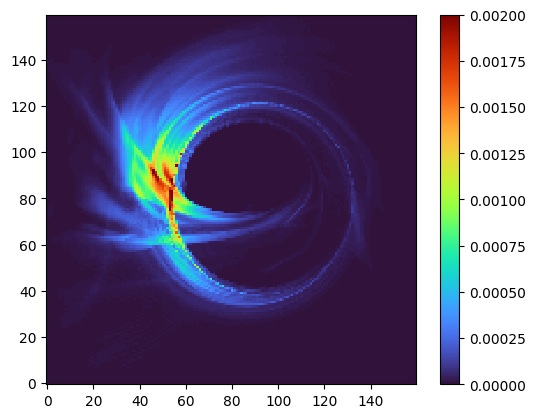

In [75]:
im1 = plt.imshow(I_new.reshape((160, 160)).T, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')
plt.colorbar(im1)
plt.savefig('test.png')

In [45]:

KuUu = local_nu / observing_frequency

EE = 4.8032e-10
KB = 1.3807e-16
CL = 2.99792458e10
ME = 9.1094e-28
HPL = 6.6261e-27
GNEWT = 6.6743e-8

N = len(emissivity)
I_new = np.zeros(len(emissivity[0]))
I_list = np.zeros((N, len(emissivity[0])))
for i in range(N-1,0,-1):
    val =  (-(final_dt[i-1,:]) * (GNEWT*M_bh/CL**2) * (emissivity[i,:]/abs(KuUu[i,:])**2 -  (abs(KuUu)[i,:] * absorptivity[i,:] * I_new)))
    I_new = I_new + val

    I_list[N-i,:] = val
#return I_new, I_list

In [46]:
I_list = np.array(I_list)


(2797, 25600)

In [59]:
np.max(I_list, axis=0).max()

0.00023485386918764561

In [63]:
I_new.max()

Array(0.00218731, dtype=float32)

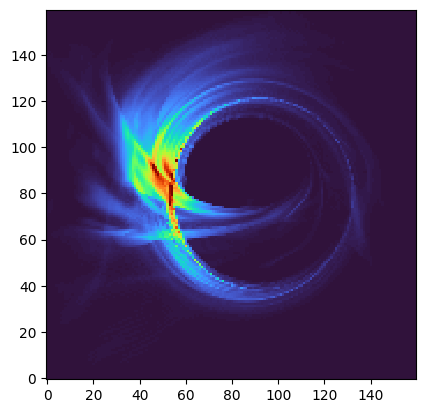

In [65]:

#plt.imshow(np.max(I_list, axis=0).reshape((160, 160)))

plt.imshow(I_new.reshape((160, 160)).T, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')

In [ ]:
def specific_intensity_bbb(N,synemiss_data,absorption_data,nu,KuUu,dt):
    '''
    !@brief This function calculates the specific intensity of the plasma
    @param N The number of photons
    @param synemiss_data The synchrotron emissivity of the plasma
    @param absorption_data The absorption coefficient of the plasma
    @param nu The frequency of the photon
    @param KuUu The 4-velocity of the photon
    @param dt The time step
    @returns The specific intensity of the plasma
    '''
    I_new = np.zeros(len(synemiss_data[0]))
    I_list = np.zeros((N,2048))
    for i in range(N-1,0,-1):
        val =  (-(dt[i-1,:]) * (G*M_BH/c**2) * (synemiss_data[i,:]/abs(KuUu[i,:])**2 -  (abs(KuUu)[i,:] * absorption_data[i,:] * I_new)))
        I_new = I_new + val

        I_list[N-i,:] = val
    return I_new, I_list

In [11]:
I_inv_list = solve_specific_intensity_mine(invariant_emissivity, invariant_absorptivity, units['T_unit'] * final_dt)

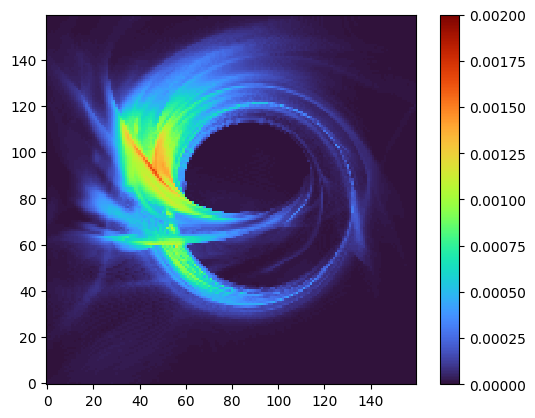

In [41]:
image_to_plot = I_inv_list[-1].reshape((number_pixels_across, number_pixels_across)).T * observing_frequency**3. / 2.259

im1 = plt.imshow(image_to_plot, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')
plt.colorbar(im1)

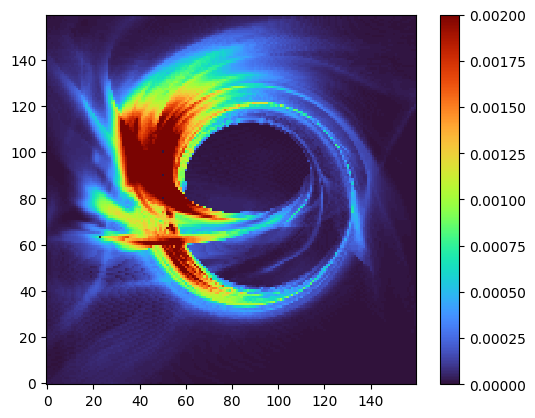

In [216]:
"""
ipx = 160*50 + 90
I_inv_list[-1][ipx] = 0.
image_to_plot = I_inv_list[-1].reshape((number_pixels_across, number_pixels_across)).T * observing_frequency**3.



im1 = plt.imshow(image_to_plot, origin='lower', cmap='turbo', vmin=0, vmax=0.002, interpolation='none')
plt.colorbar(im1)
"""

In [191]:
final_image.max()

nan

In [196]:
np.nanmax(invariant_absorptivity)

5.5535435e+20

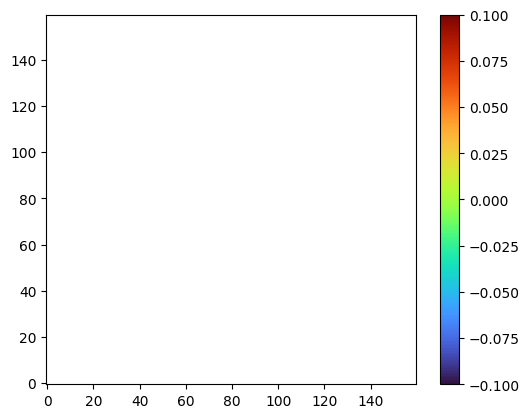

In [192]:
#plt.imshow(np.log10(final_I[-2].reshape(80,80)), origin='lower', cmap='inferno')

I_min = 1.e-100

image_to_display = final_image.copy()
image_to_display[image_to_display < I_min] = I_min
image_to_display *= observing_frequency

ax1 = plt.subplot(1, 1, 1)
#ax1.imshow(np.log10(final_image).T, cmap='afmhot', vmin=-4, vmax=0, origin='lower')
#im1 = ax1.imshow(final_image.T, cmap='turbo', vmin=0, vmax=0.002, origin='lower')
im1 = ax1.imshow(image_to_display.T, cmap='turbo', vmin=0, origin='lower')

plt.colorbar(im1)

In [46]:
def get_ks_pos_from_cks(x, y, z, bhspin):
    R = np.sqrt(np.power(x, 2.) + np.power(y, 2.) + np.power(z, 2.))
    r = np.sqrt(R**2 - bhspin*bhspin + np.sqrt(np.power(np.power(R, 2.) - bhspin*bhspin, 2.) + 
                                               4.*bhspin*bhspin * np.power(z, 2.))) / np.sqrt(2.)
    h = np.arccos(z / r)
    p = np.arctan2(bhspin*x - r*y, bhspin*y + r*x)
    return r, h, p

In [13]:
traj_out = []
traj_integration_out =[]
with open('/home/george/sites/liamedeiros/Mahakala/nox/traj_23_63.out', 'r') as fp:
    for line in fp.readlines():
        ltoks = line.split()
        if len(ltoks) == 0:
            continue
        if ltoks[0] == 'TRAJ':
            traj_out.append([float(x) for x in ltoks[1:]])
        if ltoks[0] == 'INTEGRATION':
            traj_integration_out.append([float(x) for x in ltoks[1:]])
        
traj_out = np.array(traj_out).T
traj_integration_out = np.array(traj_integration_out).T

In [14]:
ts_ipole, rs_ipole, hs_ipole, ps_ipole, b_ipole, ne_ipole, thetae_ipole, nu_ipole, mu_ipole, sigma_ipole, beta_ipole, jinv_ipole, alphainv_ipole, Iunpol_ipole = traj_out

In [15]:
# print, nstep, ti.X[1], ti.X[2], ti.X[3], Xg[1], Xg[2], Xg[3], ji, *Intensity, ti.dl
print_ipole, nstep_ipole, traj0_ipole, traj1_ipole, traj2_ipole, traj3_ipole, Xg1_ipole, Xg2_ipole, Xg3_ipole, ji_ipole, I_ipole, dl_ipole = traj_integration_out

In [18]:
ipx = 160*50 + 90

print(ipx)

ts, xs, ys, zs = S[:, ipx, :4].T

8090


In [19]:
rs, hs, ps = get_ks_pos_from_cks(xs, ys, zs, bhspin)

NameError: name 'get_ks_pos_from_cks' is not defined

(-1040.0, -1020.0)

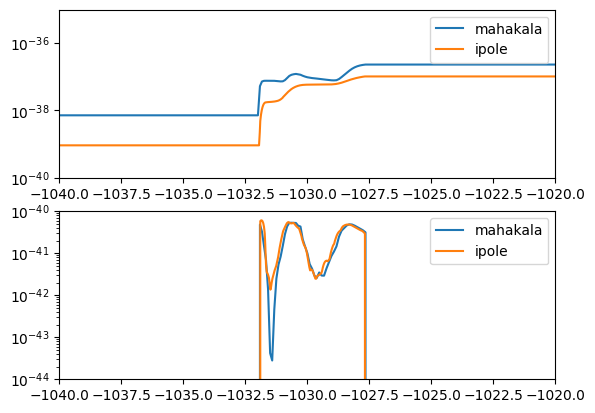

In [34]:
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

#ax1.plot(ts, fluid_scalars['dens'][:, ipx])
#ax1.plot(ts_ipole, ne_ipole / units['Ne_unit'])

#ax1.plot(ts_ipole, b_ipole)
#ax1.plot(ts, B_in_gauss[:, ipx])

#ax1.plot(ts_ipole, thetae_ipole)
#ax1.plot(ts, Theta_e[:, ipx])

#ax1.plot(ts_ipole, nu_ipole)
#ax1.plot(ts, local_nu[:, ipx])

if False:
    ax1.plot(ts_ipole, jinv_ipole)
    ax1.plot(ts, invariant_emissivity[:, ipx])
    ax1.plot(traj0_ipole, ji_ipole)

if False:
    ax1.plot(ts_ipole, alphainv_ipole)
    ax1.plot(ts, invariant_absorptivity[:, ipx])

#ax1.plot(ts_ipole, Iunpol_ipole, label='ipole')
if True:
    ax1.plot(ts[1:], I_inv_list[::-1, ipx], label='mahakala')
    ax1.plot(traj0_ipole, I_ipole, label='ipole')
    ax1.legend()
    ax1.set_ylim(1.e-40, 1.e-35)
    ax1.set_yscale('log')

#ax2.plot(ts_ipole, jinv_ipole)
ax2.plot(ts, invariant_emissivity[:, ipx], label='mahakala')
ax2.plot(traj0_ipole, ji_ipole, label='ipole')
ax2.set_yscale('log')
ax2.set_ylim(1.e-44, 1.e-40)
ax2.legend()

if False:
    ax2.plot(ts_ipole, np.exp(rs_ipole))
    ax2.set_ylim(0, 100)

xlim = [-1040, -1020]
ax1.set_xlim(*xlim)
ax2.set_xlim(*xlim)

In [39]:
I_inv_list[::-1, ipx][10] / I_ipole[-10]

2.2595237664894983

In [40]:
2.2595237664894983

2.2595237664894983

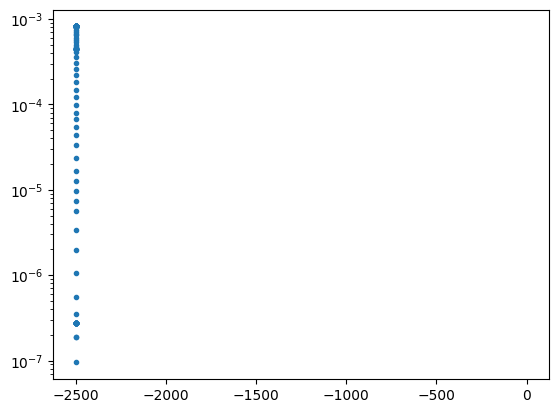

In [136]:
plt.plot(ts[:-1], final_I[:, ipx], '.')
plt.yscale('log')

In [98]:
vv = invariant_emissivity[:, ipx]
vv[vv>0].min()

Array(1.e-45, dtype=float32)

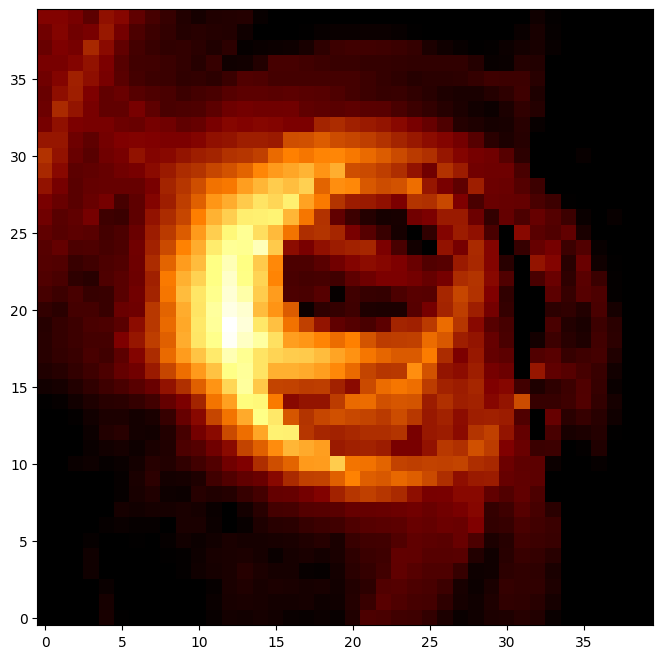

In [33]:
fig = plt.figure(figsize=(8, 8), facecolor='w')

final_image = final_image / np.max(final_image)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(np.log10(final_image).T, cmap='afmhot', vmin=-4, vmax=0, origin='lower')

# checks

In [ ]:
primitive_data_og_40sq = np.load('prim_data_og_40sq.npy', allow_pickle=True).item()

print(np.allclose(primitive_data_og_40sq['dens'], prim_data['dens'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['u'], prim_data['u'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U1'], prim_data['U1'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U2'], prim_data['U2'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['U3'], prim_data['U3'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B1'], prim_data['B1'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B2'], prim_data['B2'], atol=1e-3))
print(np.allclose(primitive_data_og_40sq['B3'], prim_data['B3'], atol=1e-3))